<a href="https://colab.research.google.com/github/SzymonNowakowski/Workshops/blob/2023_1_solutions/Day1/1_simple_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this workshop, we will dive into a construction of a simple MultiLayer Perceptron neural network. A MultiLayer Perceptron, also termed MLP, is a simple network consisting of a few fully connected linear layers 

![MLP - image from https://www.researchgate.net/publication/341626283_Prioritizing_and_Analyzing_the_Role_of_Climate_and_Urban_Parameters_in_the_Confirmed_Cases_of_COVID-19_Based_on_Artificial_Intelligence_Applications](https://i.imgur.com/8cw4GD3.png)

Linear layers must be separated by nonlinear components (also called *activation functions*). 

![non-linear components - image from https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron](https://imgur.com/L3YxcSs.png)

### Your task #1

What is the purpose of the non-linearities in-between the layers of the neural network?

### Answers to task #1
A nonlinear component in-between the linear layers is essential: 
1. without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network. 
2. it is a nonlinear component that enables a neural network to express nonlinear functions, too.

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits 0-9. MNIST stands for Modified National Institute of Standards and Technology database.

You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).

# Before we begin

There is a departure from the neuron-like biological terminology in ANN community. You will see even in this very simple example, that it is more convenient to think of layers not as of data points (neurons) but as of mathematical transformations (so a layer would be a matrix multiplication by weights or a layer would be aplication of nonlinear transform, or both, and in this latter case a layer would decompose further). 

In the case of more complex networks like Transformers it would be even hard to find a neuron analogy. Transformers explicitly work with matrices and generally with mathematical abstractions.

The departure from the neural terminology is also justified by biology, itself. It turns out, that a single neuron in a brain behaves much more like a full artificial neural network than like an artificial neuron. 

The authors of the paper cited below show that, at the very least, a 5-layer 128-unit TCN — temporal convolutional network — is needed to simulate the I/O patterns of a pyramidal neuron at the millisecond resolution (single spike precision). To make a gross comparison: This means a single biological neuron needs between 640 and 2048 artificial neurons to be simulated adequately.

[Beniaguev D, Segev I, London M. Single cortical neurons as deep artificial neural networks. Neuron. 2021 Sep 1;109(17):2727-2739.e3. doi: 10.1016/j.neuron.2021.07.002](https://pubmed.ncbi.nlm.nih.gov/34380016/)

For the interested reader: [here you can read about Transformers](https://jalammar.github.io/illustrated-transformer/).

In [86]:
import torch
import torchvision
from matplotlib import pyplot

### Reading MNIST data set

In [87]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

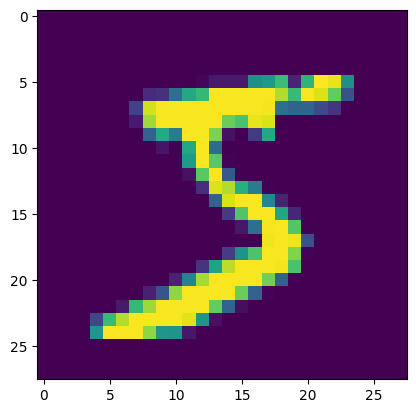

In [88]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [89]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [90]:
trainset[0][1]    #check if you classified it correctly in your mind

5


### Your task #2

Examine a few more samples from mnist dataset. Try to guess the correct class correctly, classifing images with your human classification skills. Try to estimate the accuracy, i.e. what is your percentage of correct classifications - treating a training set that we are examining now as a test set for you. It is sound, because you have not trained on that set before attempting the classification.


### Your task #3

Try to convert the dataset into numpy `ndarray`. Then estimate mean and standard deviation of MNIST dataset. Please remember that it is customary to first divide each value in MNIST dataset by 255, to normalize the initial pixel RGB values 0-255 into (0,1) range.

*Tips:* 
- to convert MNIST dataset to numpy, use `trainset.data.numpy()`
- in numpy, there are methods `mean()` and `std()` to calculate statistics of a vector. 

In [91]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(0.1306604762738429, 0.30810780385646264)

Now, we will reread the dataset (**train** and **test** parts) and transform it (standardize it) so it will be zero-mean and unit-std. 

In [92]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

Let us visualise the training labels

In [93]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([4, 0, 4,  ..., 1, 8, 7])
1 -th batch labels : tensor([7, 1, 4,  ..., 4, 2, 1])
2 -th batch labels : tensor([8, 1, 2,  ..., 6, 5, 7])
3 -th batch labels : tensor([2, 2, 7,  ..., 0, 3, 4])
4 -th batch labels : tensor([9, 1, 0,  ..., 7, 7, 9])



### Your taks #4

A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch. 

Your task is to visualise and inspect the number of orders in data in batch_inputs.

In [94]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by ToTensor() transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten()` layer or by using `squeeze()` on a tensor.

### MLP

Now, a definition of a simple MLP network.

In [95]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way, 
                                          #that output from a preceding layer serves as input to the next layer 
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.Sigmoid(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.Sigmoid(),
            torch.nn.Linear(2048, 256),
            torch.nn.Sigmoid(),            #Sigmoid is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

### Training

Training consists of 
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- running through multiple epochs and updating the network weights

In [96]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)
        
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear 
                                            #and MLP doesn't apply 
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item()) 
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network. 
                                ####You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 2.320082187652588
epoch: 0 batch: 1 current batch loss: 2.4529953002929688
epoch: 0 batch: 2 current batch loss: 2.3369109630584717
epoch: 0 batch: 3 current batch loss: 2.2928473949432373
epoch: 0 batch: 4 current batch loss: 2.29526948928833
epoch: 0 batch: 5 current batch loss: 2.3071696758270264
epoch: 0 batch: 6 current batch loss: 2.2649247646331787
epoch: 0 batch: 7 current batch loss: 2.241553544998169
epoch: 0 batch: 8 current batch loss: 2.187735080718994
epoch: 0 batch: 9 current batch loss: 2.148198366165161
epoch: 0 batch: 10 current batch loss: 2.090977430343628
epoch: 0 batch: 11 current batch loss: 2.030855894088745
epoch: 0 batch: 12 current batch loss: 1.9510005712509155
epoch: 0 batch: 13 current batch loss: 1.865456223487854
epoch: 0 batch: 14 current batch loss: 1.768835186958313
epoch: 0 batch: 15 current batch loss: 1.658790111541748
epoch: 0 batch: 16 current batch loss: 1.6109082698822021
epoch: 0 batch: 17 current batch lo


### Your task #5

Comment the line `optimizer.step()` above. Rerun the above code. Note that the loss is NOT constant as the comment in the code seems to promise, but anyway, the loss doesn't improve, either. Please explain, why the loss is not constant. Please explain, why the loss doesn't improve, either.

An epoch is a one full passage through the whole training data. Why then, on the second epoch, the losses are different than in the first epoch?

### Answers to task #5

The loss is not constant because in our code we are printing losses in batches, and each batch is a different data sample. A loss value calculated on different data sample may be different. Moreover, the second epoch and subsequent epochs, i.e. next runs through the whole data, they consist of different randomly shuffled batches, because we selected `shuffle = True` when initiating a training dataset. It means, that even in next epochs, batched samples will be different samples and the loss values may differ.

But overall, loss desn't improve because the weights in the network do not change. The line responsible for changing the weights in the network is commented. 

### Training - the second approach


Sometimes during training loss stabilizes and doesn't improve anymore. It is not the case here (yet, but we have only run 8 epochs), but a real problem in practice.
We can include a new tool called a **scheduler** that would update the *learning rate* in an otpimizer after each epoch. This usually helps the training. Let us reformulate the traning so it consists of 
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- a definition of a scheduler to update the learning rate in an optimizer
- running through multiple epochs and updating the network weights

In [97]:
net_with_scheduler = MLP()
optimizer = torch.optim.Adam(net_with_scheduler.parameters(), 0.001)   #initial learning rate of 0.001. 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)    #updates the learning rate after each epoch. There are many ways to do that: StepLR multiplies learning rate by gamma

net_with_scheduler.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)
        
        optimizer.zero_grad()

        batch_outputs = net_with_scheduler(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear 
                                            #and MLP doesn't apply 
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item(), "current lr:", scheduler.get_last_lr()[0]) 
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network. 
                                
    scheduler.step()

epoch: 0 batch: 0 current batch loss: 2.37093448638916 current lr: 0.001
epoch: 0 batch: 1 current batch loss: 2.3960514068603516 current lr: 0.001
epoch: 0 batch: 2 current batch loss: 2.386112689971924 current lr: 0.001
epoch: 0 batch: 3 current batch loss: 2.327414035797119 current lr: 0.001
epoch: 0 batch: 4 current batch loss: 2.309817314147949 current lr: 0.001
epoch: 0 batch: 5 current batch loss: 2.2888028621673584 current lr: 0.001
epoch: 0 batch: 6 current batch loss: 2.2699129581451416 current lr: 0.001
epoch: 0 batch: 7 current batch loss: 2.2731716632843018 current lr: 0.001
epoch: 0 batch: 8 current batch loss: 2.2644124031066895 current lr: 0.001
epoch: 0 batch: 9 current batch loss: 2.2327938079833984 current lr: 0.001
epoch: 0 batch: 10 current batch loss: 2.1863491535186768 current lr: 0.001
epoch: 0 batch: 11 current batch loss: 2.132901430130005 current lr: 0.001
epoch: 0 batch: 12 current batch loss: 2.0757265090942383 current lr: 0.001
epoch: 0 batch: 13 current b

 
### Your task #6

Well, it seems that we were able to get the learning to levels of 0.1 even without a scheduler. Can you bring it under 0.05? Can you keep it under 0.05? Maybe the proposed gamma was to low (0.9 only)?. Please experiment with different settings for the optimizer learning rate and different scheduler settings. There are other schedulers you can experiment with, too. Please verify what would happen if the nets were allowed to train for more training epochs.

Some other schedulers you might want to experiment with: 
- Exponential LR - decays the learning rate of each parameter group by gamma every epoch - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html) 
- Step LR - more general then the Exponential LR: decays the learning rate of each parameter group by gamma every step_size epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)
- Cosine Annealing LR - learning rate follows the first quarter of the cosine curve - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
- Cosine with Warm Restarts - learning rate follows the first quarter of the cosine curve and restarts after a predefined number of epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html)

### Your task #7

Please explain, what are the dangers of bringing the loss too low? What is an *overtrained* neural network? How can one prevent it?

### Testing

Now we will test those two nets - the one without and the one with the scheduler.

In [98]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

accuracy =  0.9687


In [99]:
good = 0
wrong = 0

net_with_scheduler.eval()   #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():       #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1

        datapoint, label = data

        prediction = net_with_scheduler(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)                   #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

accuracy =  0.9607


Well, not bad. Now it is your turn to experiment - change the number and sizes of layers in out neural networks, change the activation function, play with the learning rate and the optimizer and the scheduler.

# Phase 2 Hands on

## Moving computations to GPU

In the code above we didn't move the computations to GPU. The first task is moving the computations to GPU. How do you do that?

Ability to compute on GPU is called CUDA:  Compute Unified Device Architecture.

First, we check if CUDA is available:

In [100]:
torch.cuda.is_available()

True

How to make CUDA available if it is not? 

* On a local machine you must connect and properly configure a GPU card, it is out of scope of this workshop.

* In Google Colab online, you click `Runtime` > `Change runtime` and change `Hardware acceleration` setting to `GPU`.

* In Google Colab **Polish version**, you click `Środowisko wykonawcze` > `Zmień typ środowiska wykonawczego` and change `Akcelerator sprzętowy` setting to `GPU`.

Once we have CUDA (or not: this case should be handled in the code, too), we are ready to determine the calculation device. Note that it is just a character string:


In [101]:
if torch.cuda.is_available():
  computational_device = 'cuda'
else:
  computational_device = 'cpu'

print(computational_device)

cuda


Then we move our neural network model and each tensor with batch data to GPU. We can do it by passing the `device = computational_device` argument during the model or tensor construction, or by calling a `to(computational_device)` method on a model or a tensor:

In [102]:
layer = torch.nn.Linear(2048, 256, device = computational_device),
layer = torch.nn.Linear(2048, 256).to(computational_device)

## Task

Enable CUDA compuations in all the code above:

1. Check if CUDA is available before the MLP definition
2. Add the device field to the constructor and pass it to all constructed layers
3. Add the device argument when constructing MLP
4. Add the device arguments to all tensors that get passed to MLP

In [103]:
########################################### check  if CUDA available #################################################
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

########################################### MLP definition on GPU #################################################
class MLP(torch.nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   
                                          
            torch.nn.Flatten(),   
            torch.nn.Linear(1*28*28, 1024, device = device),   # device gets passed to every layer in the Sequential
            torch.nn.Sigmoid(),
            torch.nn.Linear(1024, 2048, device = device), # device gets passed to every layer in the Sequential   
            torch.nn.Sigmoid(),
            torch.nn.Linear(2048, 256, device = device),  # device gets passed to every layer in the Sequential
            torch.nn.Sigmoid(),            
            torch.nn.Linear(256, 10, device = device)    # device gets passed to every layer in the Sequential
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

########################################### TRAINING ON GPU #################################################  
net = MLP(device = device)       #we build MLP on a computational_device
optimizer = torch.optim.Adam(net.parameters(), 0.001)   

net.train()    
for epoch in range(8):  

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
               
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs.to(device))  # we move batch data to computational_device
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels.to(device), reduction = "mean") # we move batch labels to computational_device
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item()) 
        loss.backward()       
        optimizer.step()     



epoch: 0 batch: 0 current batch loss: 2.3481287956237793
epoch: 0 batch: 1 current batch loss: 2.3892431259155273
epoch: 0 batch: 2 current batch loss: 2.3532729148864746
epoch: 0 batch: 3 current batch loss: 2.3040623664855957
epoch: 0 batch: 4 current batch loss: 2.27738618850708
epoch: 0 batch: 5 current batch loss: 2.2874906063079834
epoch: 0 batch: 6 current batch loss: 2.279979944229126
epoch: 0 batch: 7 current batch loss: 2.255964517593384
epoch: 0 batch: 8 current batch loss: 2.209552526473999
epoch: 0 batch: 9 current batch loss: 2.159940242767334
epoch: 0 batch: 10 current batch loss: 2.108581304550171
epoch: 0 batch: 11 current batch loss: 2.0502569675445557
epoch: 0 batch: 12 current batch loss: 1.9889990091323853
epoch: 0 batch: 13 current batch loss: 1.8882744312286377
epoch: 0 batch: 14 current batch loss: 1.7890307903289795
epoch: 0 batch: 15 current batch loss: 1.7028944492340088
epoch: 0 batch: 16 current batch loss: 1.6057438850402832
epoch: 0 batch: 17 current batc

In [104]:
################################################ TESTING ON GPU #####################################################
good = 0
wrong = 0

net.eval()              
with torch.no_grad():   
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))                  # moving a batch to GPU
        classification = torch.argmax(prediction)    

        if classification.item() == label.item():     # the comparison is on item() which is not a tensor, i.e. there is no need to move labels to GPU
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

accuracy =  0.9686


## Desequencing forward computations

In the MLP definition above we used a sequential layer. In order to demonstrate how in general one can perform arbitrary forward computations, we will remove the sequential layer now.

## Task

Remove the sequential layer

1. Remove the sequential layer by using separate variables for the layers within.
2. Change the forward flow to pass `x` through all layers.


In [105]:

########################################### MLP definition without sequential #################################################
class MLP(torch.nn.Module):
    def __init__(self, device):
        super(MLP, self).__init__()
        self.flatten = torch.nn.Flatten()   
        self.linear1 = torch.nn.Linear(1*28*28, 1024, device = device)  
        self.linear2 = torch.nn.Linear(1024, 2048, device = device)   
        self.linear3 = torch.nn.Linear(2048, 256, device = device)
        self.linear4 = torch.nn.Linear(256, 10, device = device)   

        self.sigmoid = torch.nn.Sigmoid()    #only one of those is needed in the current setup

        self.linear_res = torch.nn.Linear(2048, 2048, device = device)     # a layer not changing shape of input, it will be used as an example of residual skip connection layer

    def forward(self, x):
        x = self.flatten(x)         # we pass x sequentially through all layers and sigmoids in our network
        x = self.linear1(x)
        x = self.sigmoid(x)     
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = x ** 2 + self.linear_res(x)  # an example of residual skip connections, usually one skips layers with x, not x^2, 
                                         # but this layer is linear and I wanted to accentuate the example you can code the forward pass completely freely
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)
        
        return x

########################################### TRAINING ARBITRARY COMPUTATIONS NET #################################################  
net = MLP(device = device)       
optimizer = torch.optim.Adam(net.parameters(), 0.001)   

net.train()    
for epoch in range(8):  

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
               
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs.to(device))  
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels.to(device), reduction = "mean") # we move batch labels to computational_device
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item()) 
        loss.backward()       
        optimizer.step()     



epoch: 0 batch: 0 current batch loss: 2.3419530391693115
epoch: 0 batch: 1 current batch loss: 2.4762277603149414
epoch: 0 batch: 2 current batch loss: 2.4134438037872314
epoch: 0 batch: 3 current batch loss: 2.331651449203491
epoch: 0 batch: 4 current batch loss: 2.323476791381836
epoch: 0 batch: 5 current batch loss: 2.3259336948394775
epoch: 0 batch: 6 current batch loss: 2.3308041095733643
epoch: 0 batch: 7 current batch loss: 2.3320274353027344
epoch: 0 batch: 8 current batch loss: 2.315993070602417
epoch: 0 batch: 9 current batch loss: 2.2989156246185303
epoch: 0 batch: 10 current batch loss: 2.279228448867798
epoch: 0 batch: 11 current batch loss: 2.2762129306793213
epoch: 0 batch: 12 current batch loss: 2.25650954246521
epoch: 0 batch: 13 current batch loss: 2.243849515914917
epoch: 0 batch: 14 current batch loss: 2.222565174102783
epoch: 0 batch: 15 current batch loss: 2.186673879623413
epoch: 0 batch: 16 current batch loss: 2.1543729305267334
epoch: 0 batch: 17 current batch 

In [106]:
################################################ TESTING ARBITRARY COMPUTATIONS NET #####################################################
good = 0
wrong = 0

net.eval()              
with torch.no_grad():   
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))                  
        classification = torch.argmax(prediction)    

        if classification.item() == label.item():    
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

accuracy =  0.9681


## LeNet implementation

In the MLP definition above we used linear layers. Now we will implement LeCun network consisting of convolutional layers. Convolutions are much better suited for image analysis than linear layers.

![LeNet](https://miro.medium.com/v2/resize:fit:1400/1*LYiQq1Gg_yHKszun23MocQ.png)
(above: LeNet image from https://medium.com/mlearning-ai/lenet-and-mnist-handwritten-digit-classification-354f5646c590 by Khuyen Le)


![LeNet from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg)



## Task
Replace the network definition with 2D covolutions as per the pictures above.

Train and test the network.

In [107]:

########################################### LeCun definition without sequential #################################################
class LeNet(torch.nn.Module):
    def __init__(self, device):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels = 6, kernel_size = 5, stride = 1, device = device)
        self.pool1 = torch.nn.AvgPool2d(kernel_size = 2)
        self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, device = device)
        self.pool2 = torch.nn.AvgPool2d(kernel_size = 2)
        
        self.linear1 = torch.nn.Linear(256, 120, device = device)   # how did I get that 256 dimension? I printed the size of x trensor after flatten
        self.linear2 = torch.nn.Linear(120, 84, device = device)
        self.linear3 = torch.nn.Linear(84, 10, device = device)

        self.sigmoid = torch.nn.Sigmoid()    # only one of those 2 is needed in the current setup
        self.flatten = torch.nn.Flatten()   


    def forward(self, x):
   
        x = self.conv1(x)   # we pass x sequentially through all layers and sigmoids in our network
        x = self.sigmoid(x)     
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.sigmoid(x)
        x = self.pool2(x)

        x = self.flatten(x)

        #print(x.size())              # how did I get that 256 dimension? I printed the size of x trensor after flatten
        
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)

        return x

########################################### TRAINING ARBITRARY COMPUTATIONS NET #################################################  
net = LeNet(device)       
optimizer = torch.optim.Adam(net.parameters(), 0.001)   

net.train()    
for epoch in range(16):  

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
               
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs.to(device))  
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels.to(device), reduction = "mean") # we move batch labels to computational_device
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item()) 
        loss.backward()       
        optimizer.step()     



epoch: 0 batch: 0 current batch loss: 2.3530161380767822
epoch: 0 batch: 1 current batch loss: 2.3293988704681396
epoch: 0 batch: 2 current batch loss: 2.316072702407837
epoch: 0 batch: 3 current batch loss: 2.3088676929473877
epoch: 0 batch: 4 current batch loss: 2.304442882537842
epoch: 0 batch: 5 current batch loss: 2.304818630218506
epoch: 0 batch: 6 current batch loss: 2.3059606552124023
epoch: 0 batch: 7 current batch loss: 2.3024609088897705
epoch: 0 batch: 8 current batch loss: 2.3015835285186768
epoch: 0 batch: 9 current batch loss: 2.3043456077575684
epoch: 0 batch: 10 current batch loss: 2.3076493740081787
epoch: 0 batch: 11 current batch loss: 2.304929256439209
epoch: 0 batch: 12 current batch loss: 2.3100481033325195
epoch: 0 batch: 13 current batch loss: 2.3074402809143066
epoch: 0 batch: 14 current batch loss: 2.3101775646209717
epoch: 0 batch: 15 current batch loss: 2.303358316421509
epoch: 0 batch: 16 current batch loss: 2.301790475845337
epoch: 0 batch: 17 current bat

In [108]:
################################################ TESTING LeNet #####################################################
good = 0
wrong = 0

net.eval()              
with torch.no_grad():   
    for batch, data in enumerate(testloader): 
        datapoint, label = data

        prediction = net(datapoint.to(device))                  
        classification = torch.argmax(prediction)    

        if classification.item() == label.item():    
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

accuracy =  0.9383


# Phase 3 What next

First and foremost - **save your updated Colab notebook into GDrive**, so you can work with it later. 

Then - experiment yourself. Try to add a scheduler into LeNet training. Observe that in the final epochs the loss didn't improve much and that the final accuracy was very mediocre. It should supercede than of the MLP network!

There are also aspects of ML we didn't even touch:

1. Validation on an additional validation set, or cross-validation
2. Initializing the network
3. Choice of a scheduler (we used exclusively Adam)
4. Choice of a batch size and accompanying learning rate
5. Choice of a specific loss function for very specific tasks

Those concepts constitute a broad and separate subject, each of them. Explore them and have fun!